<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/05_trasnfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with Tensorflow Part 2: Fine-tuning.

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of tranfer learning **Fine-tuning**

In [2]:
# Check if we are using GPU.
!nvidia-smi

Sun Aug 31 12:35:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Creating helper functions.

In the previous notebooks, we've created a bunch of helper functions, now we coulld write them up but it's better we import them.

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-08-31 12:35:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-31 12:35:08 (31.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Importing helper functions to use in this notebook.

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

 ## Get some data.

We will get 10% of training data of 10 classes of Food101

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-08-30 02:08:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 8.5s    

2025-08-30 02:09:01 (19.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# walk through diercitory.
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directory paths.

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"



In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

NameError: name 'train_dir' is not defined

In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# See an example of a batch of data.
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.84339279e+02 1.91339279e+02 1.84339279e+02]
   [1.85000000e+02 1.92000000e+02 1.85000000e+02]
   [1.86000000e+02 1.91000000e+02 1.85000000e+02]
   ...
   [1.33535690e+02 9.45356903e+01 5.15356941e+01]
   [1.32707916e+02 9.37079163e+01 5.07079163e+01]
   [1.34321426e+02 9.53214264e+01 5.23214302e+01]]

  [[1.86006378e+02 1.93006378e+02 1.86006378e+02]
   [1.85088013e+02 1.92088013e+02 1.85088013e+02]
   [1.85000000e+02 1.90000000e+02 1.84000000e+02]
   ...
   [1.30982147e+02 9.19821396e+01 4.89821434e+01]
   [1.30053589e+02 9.10535812e+01 4.80535851e+01]
   [1.30982147e+02 9.19821396e+01 4.89821434e+01]]

  [[1.86804855e+02 1.93804855e+02 1.86804855e+02]
   [1.86000000e+02 1.93000000e+02 1.86000000e+02]
   [1.85547195e+02 1.90547195e+02 1.84547195e+02]
   ...
   [1.29303574e+02 9.03035736e+01 4.73035698e+01]
   [1.29668365e+02 9.06683655e+01 4.76683617e+01]
   [1.29303574e+02 9.03035736e+01 4.73035698e+01]]

  ...

  [[1.34593246e+02 1.20986076e+02 1.13289665e+02]
   [1

In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Building a transfer learning model using the Keras Functional API. Feature Extraction

In [ ]:
# 1. Create base model with tf.keras.applications.
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

# 2. Freeze the base model(so the underlying pre-trained patterins arein't updated)
base_model.trainable = False

# 3. Create inputs into our model.
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs.
# x = tf.keras.layers.preprocessing.Rescaling(1./255)

# 4. pass the inpusts to beh base_model.
x = base_model(inputs)
print(f"Shape after base model: {x.shape}")

# 5. Average pool the outputs of the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 7. Combine the inputs with the outputs into a model.
model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after base model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)


In [ ]:
# Compile the model.
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# fit the model.
model_0_history = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    validation_data = test_data,
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2411 - loss: 2.1646 - val_accuracy: 0.6940 - val_loss: 1.3692
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7355 - loss: 1.2161 - val_accuracy: 0.8052 - val_loss: 0.9067
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8244 - loss: 0.8415 - val_accuracy: 0.8324 - val_loss: 0.7179
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.8632 - loss: 0.6519 - val_accuracy: 0.8424 - val_loss: 0.6272
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.8766 - loss: 0.5692 - val_accuracy: 0.8504 - val_loss: 0.5691


In [ ]:
# evaluate our model.
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8446 - loss: 0.5594


[0.56911301612854, 0.8503999710083008]

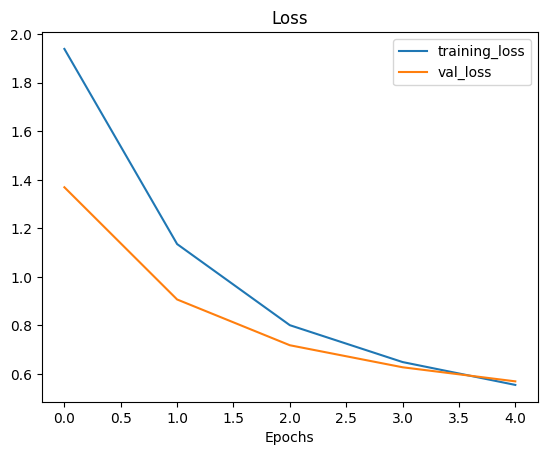

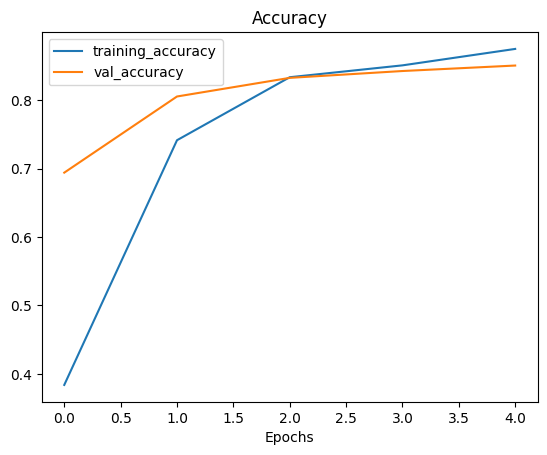

In [ ]:
# plot loss curves.
plot_loss_curves(model_0_history)

In [ ]:
# Check layers in our base model.
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

## Getting a feature vector from a trained model.

Let's demonsrate the Gloabl Average Pooling 2D layer...


We have a tensor after our model goes through 'base_model' it has a shape of (None, 7, 7, 1280).

when it passes through our GlobalAveragePooling2D, it turns into (None, 1280)

In [ ]:
# Define input shape.
input_shape = (1, 4, 4, 3)

# Create a random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: 'n {input_tensor}")


# Pass the random tensor through a global average pooling 2d.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Average Pooling 2D: {global_average_pooled_tensor.shape}")
print(f"2D Global Average Pooling 2D: {global_average_pooled_tensor}")

# check the shape of the d/f tensor.
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Average Pooling 2D: {global_average_pooled_tensor.shape}")

Random input tensor: 'n [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Average Pooling 2D: (1, 3)
2D Global Average Pooling 2D: [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Average Pooling 2D: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer.
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Lets try to use the GlobalMax2D and see how it works.

In [ ]:
# Define input shape.
input_shape = (1, 4, 4, 3)

# Create a random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: 'n {input_tensor}")


# Pass the random tensor through a global max pooling 2d.
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Max Pooling 2D: {global_max_pooled_tensor.shape}")
print(f"2D Global Max Pooling 2D: {global_max_pooled_tensor}")

# check the shape of the d/f tensor.
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Shape after Global Max Pooling 2D: {global_max_pooled_tensor.shape}")

Random input tensor: 'n [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Max Pooling 2D: (1, 3)
2D Global Max Pooling 2D: [[0.9058464 1.1603122 1.6994323]]
Shape of the random tensor: (1, 4, 4, 3)
Shape after Global Max Pooling 2D: (1, 3)


## Running a series of transfer Learning experiments.

We've seen the incredibile results transfer learning can get with only 10% f the training data, but how does it go with 1% of the training data. How about we setup a bonth of experiments to find out.

1. 'model_1' - use feature extraction tranfer learning with 1% of the training data with data augmentation.
2. 'model_2' - use feature extraction transler learning with 10% of the training with data augmetnaion.
3. 'model_3' - use fin-tuning tranfer learning on 10% of the training data with data augmentation.
4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmetnaion.

In [6]:
# Download and unzip data.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2025-08-31 12:35:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   248MB/s    in 0.5s    

2025-08-31 12:35:59 (248 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [7]:
# Walk through the directory.
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [8]:
# Create training and test dirs.
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


In [9]:
# How many images we are working with ?

import pathlib
data_dir = pathlib.Path(train_dir_1_percent)

image_count_dict = {}

for dirpath in data_dir.glob("*"):
  image_count = len(list(dirpath.glob("*")))
  image_count_dict[dirpath.name] = image_count

image_count_dict

{'fried_rice': 7,
 'steak': 7,
 'pizza': 7,
 'ice_cream': 7,
 'sushi': 7,
 'chicken_curry': 7,
 'ramen': 7,
 'chicken_wings': 7,
 'grilled_salmon': 7,
 'hamburger': 7}

In [12]:
## Setup data loaders.
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_1_percent,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir_1_percent,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
print("Number of batches in train data: ", len(train_data_1_percent))
print("Number of batches in test data: ", len(test_data_1_percent))

Number of batches in train data:  3
Number of batches in test data:  79


In [14]:
## Adding data augmentation right into our model.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, RandomContrast
# from tensorflow.keras.layers.experimental import preprocessing
# Create data augmentation stage with horizontal flipping, rotations, zooms.

data_augmentation = keras.Sequential([
    Rescaling(1./255),
    Resizing(224, 224),
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
], name="data_augmentation")

## Let's visualize our data augmentation layer on a bunch of images.

10_food_classes_1_percent/train/steak
60633.jpg


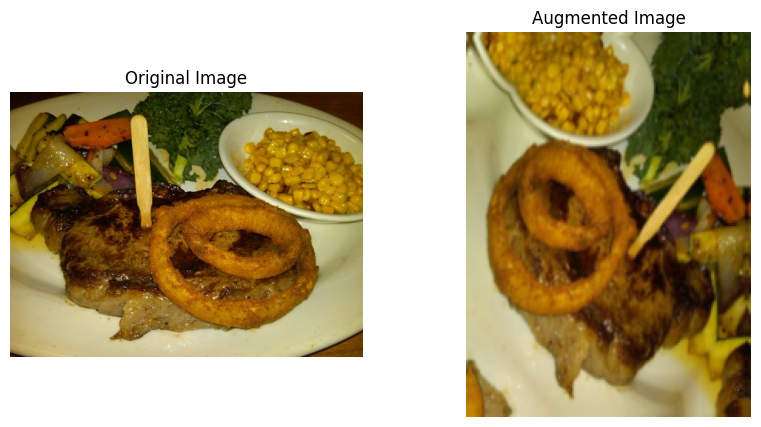

In [15]:
# View a random image and compare it to its augmented version.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)

# Read and plot in the random image
random_image = random.choice(os.listdir(target_dir))
print(random_image)
random_image_path = target_dir + "/" + random_image

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Plot the augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(augmented_img)) # Removed / 255.
plt.title("Augmented Image")
plt.axis("off")

plt.show()

# Building our Model_1 Transfer learning with EfficientNetB0 with Data Augmentation as a layer.

In [16]:
# Setup the input shape base model, freezing the base model layers.

INPUT_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

base_model.trainable = False

# Create input layer.
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer")

# add in data augmentation sequential model as a layer.
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it.
x = base_model(x, training = False)

# Pool output features of the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# put a dense layer as output.
outputs = layers.Dense(10, activation="softmax", name="output layer")(x)


model_1 = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional" is incompatible with the layer: expected shape=(None, 384, 512, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>',)
  • kwargs={'mask': 'None'}

In [17]:
# compile model.
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
Model_1_history = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    validation_data = test_data_1_percent,
    validation_steps = int(0.15 * len(test_data_1_percent)),
)

NameError: name 'model_1' is not defined

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation.

In [18]:
# Get 10% of data...

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2025-08-31 12:42:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 74.125.135.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   221MB/s    in 0.7s    

2025-08-31 12:42:13 (221 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [19]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [20]:
# How many images in our directory.
import pathlib
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [21]:
 # Set up data inputs.
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_10_percent,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir_10_percent,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
# Create model 2 with data augmentation.
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom
from tensorflow.keras.models import Sequential

# Build data augmentation layer.
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
  RandomZoom(0.2),
  # preprocessing.Rescaling(1./255)
])

In [23]:
# Create the model architecture.
from tensorflow.keras import layers

INPUT_SHAPE = (224, 224, 3)

# Create a frozen base model (call backbone)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

base_model.trainable = False

# Create inputs and outputs including layers in between.

inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(inputs)  # Augment our traniingi images
x = base_model(x, training=False) # pass augmented images to base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)



In [24]:
# Creating a modelCheckpoint callback. So it saves our model weights during training. This is usefull so we can coe and start where we left off....

checkpoint_path = "ten_percent_model/checkpoint.keras";

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

In [25]:
# Compile and fit the model.

initial_epochs = 5
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# fit the model..
model_2_history = model_2.fit(
    train_data_10_percent,
    epochs = initial_epochs,
    validation_data = test_data_10_percent,
    validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("transfer_learning", "model_2_10_percent_data_aug"), model_checkpoint]
)

Saving TensorBoard log files to: transfer_learning/model_2_10_percent_data_aug/20250831-124216
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.2300 - loss: 2.2178 - val_accuracy: 0.6941 - val_loss: 1.4209
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.6665 - loss: 1.4007 - val_accuracy: 0.8174 - val_loss: 0.9894
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7447 - loss: 1.0437 - val_accuracy: 0.8355 - val_loss: 0.7808
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - accuracy: 0.8049 - loss: 0.8593 - val_accuracy: 0.8421 - val_loss: 0.6941
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.7818 - loss: 0.7672 - val_accuracy: 0.8553 - val_loss: 0.6258


In [26]:
# Evlaute our model.
model_2.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.8559 - loss: 0.6237


[0.6251881122589111, 0.8500000238418579]

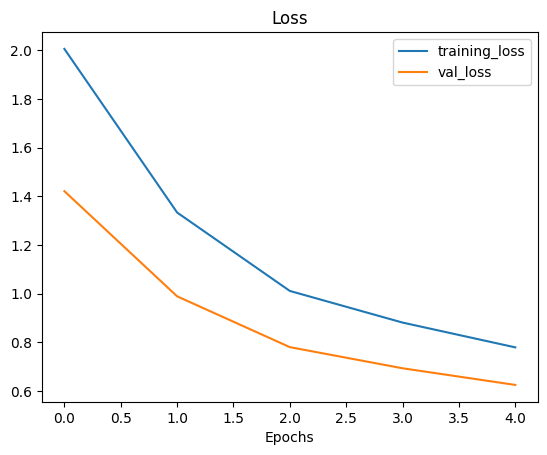

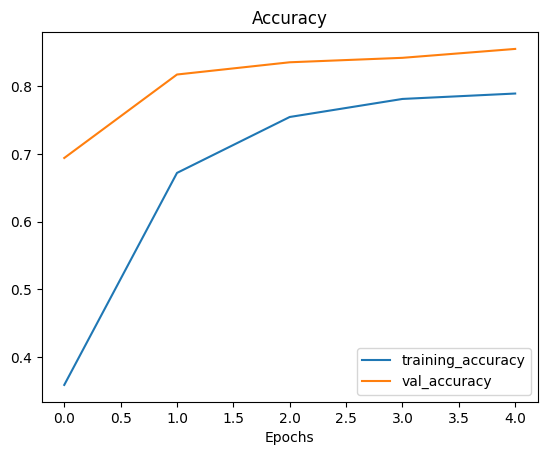

In [27]:
# plot model loss curves
plot_loss_curves(model_2_history)

## Model 3: Fine-tuning an existing model on 10% of the Data.

**Note: ** Fine-tuning usually works best *after* training a feature extraction model for a few epocs with large amounts of custom data.

In [28]:
# Layers in our loaded model.

model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [29]:
# are the layers in model_2 trainable.
for layers in model_2.layers:
  print(layers, layers.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=sequential, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [30]:
# Layers in our base model.
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,  layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_3 False
2 normalization_1 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [31]:
# How many trainable variable are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [32]:
# Now we will set the last 10 layers of our base model to true. To begin fine-tuning lets start by setting the last 10 layers of our base_model.trainable = True

# Set the entire base model to non-trainable
base_model.trainable = False

# Unfreeze the last 10 layers of the base model
for layer in base_model.layers[-10:]:
  layer.trainable = True
  print(layer.name, layer.trainable)

block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [33]:
 # Recompile our model_2.

 model_2.compile(
     loss = "categorical_crossentropy",
     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),   # When fine-tuning we typically want to lower the learning rate by 10x
     metrics = ['accuracy']
 )


# check layers that are tunable(trainalbe)
for i, layers in enumerate(model_2.layers[2].layers):
  print(i, layers, layers.trainable)

0 <InputLayer name=input_layer_2, built=True> False
1 <Rescaling name=rescaling_3, built=True> False
2 <Normalization name=normalization_1, built=True> False
3 <Rescaling name=rescaling_4, built=True> False
4 <ZeroPadding2D name=stem_conv_pad, built=True> False
5 <Conv2D name=stem_conv, built=True> False
6 <BatchNormalization name=stem_bn, built=True> False
7 <Activation name=stem_activation, built=True> False
8 <DepthwiseConv2D name=block1a_dwconv, built=True> False
9 <BatchNormalization name=block1a_bn, built=True> False
10 <Activation name=block1a_activation, built=True> False
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
12 <Reshape name=block1a_se_reshape, built=True> False
13 <Conv2D name=block1a_se_reduce, built=True> False
14 <Conv2D name=block1a_se_expand, built=True> False
15 <Multiply name=block1a_se_excite, built=True> False
16 <Conv2D name=block1a_project_conv, built=True> False
17 <BatchNormalization name=block1a_project_bn, built=True> False
18 <C

In [34]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable are they..
print(len(model_2.trainable_variables))

12


In [35]:
# Fine tune for another 5 epcosh..
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

# fit the model....
model_2_history_trasferLearning = model_2.fit(
    train_data_10_percent,
    epochs = total_epochs,
    initial_epoch = model_2_history.epoch[-1],
    validation_data = test_data_10_percent,
    validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("transfer_learning", "model_2_10_percent_data_aug"), model_checkpoint]
)

Saving TensorBoard log files to: transfer_learning/model_2_10_percent_data_aug/20250831-124319
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step - accuracy: 0.8319 - loss: 0.7599 - val_accuracy: 0.8487 - val_loss: 0.5515
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.8218 - loss: 0.6858 - val_accuracy: 0.8602 - val_loss: 0.5114
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - accuracy: 0.8531 - loss: 0.5821 - val_accuracy: 0.8569 - val_loss: 0.4893
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accuracy: 0.8791 - loss: 0.5301 - val_accuracy: 0.8553 - val_loss: 0.4740
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8777 - loss: 0.5003 - val_accuracy: 0.8684 - val_loss: 0.4569
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.8945 - loss: 0.4302 - val_accuracy: 0.8618 - val_loss: 0.4301


In [36]:
# evalute the fine-tuned model...
model_2.evaluate(test_data_10_percent)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8657 - loss: 0.4363


[0.4393045902252197, 0.8628000020980835]

In [36]:
# check out the loss curves of our fine-tune model.
plot_loss_curves(model_2_history_trasferLearning)

In [41]:
# Let's create a function to compare training histories.

def compare_histories(original_history, new_history, initial_epochs=5):
  """
    Compares 2 tensorflow history objects.
  """
  # Get original history measurements.
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine the orignla history.
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots.
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')

  plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plots for loss.
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')

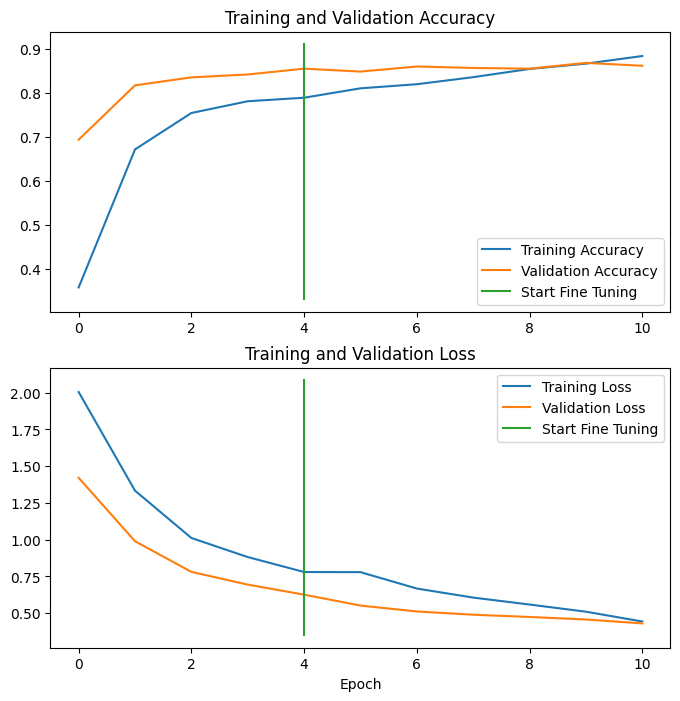

In [42]:
# call compare histories.
compare_histories(model_2_history, model_2_history_trasferLearning)

# Creating a new model with all of the 10 classes and 100% of the training data.........  

In [43]:
# import the data.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2025-08-31 12:56:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 142.251.188.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  60.0MB/s    in 6.4s    

2025-08-31 12:56:16 (78.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [44]:
# Create data loader's

train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"

In [45]:
# walk through all the direcotires.
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [46]:
# Setup data inputs and turn them into batches.

import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_all_data,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir_all_data,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Normalize our data.

